# Etape 1 - Exploration des données (y compris préprocessing)

In [1]:
# Import librairies
import csv
import pandas as pd
import nltk
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import warnings


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from utils_text_processing import *

c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\tensorflow_hub\__init__.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\tensorflow_hub\__init__.py:75: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\abes_index\lib\site-packa

gensim version: 4.3.0
tensorflow version: 2.10.0
Num GPUs Available:  0
is tf built with cuda: False


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


USE model %s loaded


In [2]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Autorisation pour la visualisation par pyLDAvis
pyLDAvis.enable_notebook()

In [4]:
# Paramètres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)
dpi = 300

In [5]:
# Import des données
#data = pd.read_csv("../data/export.dsv", sep="\t", encoding='latin-1')

In [6]:
# Import des données
with open('../data/export.dsv', 'r', newline='', encoding="latin") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t',)
    data=list(csv_reader) 

In [7]:
# Verification du format des données
df = pd.DataFrame(data[1:], columns=data[0]+["A", "B"])
print(f"le Fichier de données contient {df.shape[0]} lignes et  {df.shape[1]} colonnes")

le Fichier de données contient 89434 lignes et  7 colonnes


In [8]:
# Visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,None,None
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,None,None
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,None,None
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,None,None
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,None,None


In [9]:
# Recherche des lignes mal formattées
data_to_check = df[(~df["A"].isna()) | (~df["B"].isna())]
print("Nombre d'ouvrages avec soucis d'importation :", data_to_check.shape)
data_to_check

Nombre d'ouvrages avec soucis d'importation : (18, 7)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
12634,130654965,L'individu contre l'État,"La 4e de couverture indique :""","a Herbert Spencer (1820-1903), philosophe, éco...",Libéralisme;Libéralisme,320.510 941,None
14569,145536599,Thèbes aux 101 portes : mélanges à la mémoire ...,La nécropole thébaine attire archéologues et a...,architecture des chapelles funéraires et de le...,"arrêt sur images"", abordant par ailleurs la co...",Religion égyptienne;Religions;Égyptien ancien ...,932-933
20334,168619016,Le Paris des années 1920 : avec Kiki de Montpa...,"Paris, 1918-1928, ce sont les années folles. I...",avant- garde. Dadaïstes et surréalistes s'y di...,Artistes;Artistes et modèles;Vie intellectuell...,700,None
20654,169298116,La salope éthique : guide pratique pour des r...,,"a En 1997, un objet littéraire non identifié e...",Amour libre;Liberté sexuelle;Relations amoureuses,306.7,None
32591,193458209,Principes de marketing,"La quatrième de couv. indique : ""Écrit par les...",version française : des modules d'apprentissa...,Marketing,658.8,None
32974,193928604,Japanese,Guide de conversation Japonais pour anglophones,tous niveaux Quelques jours à Tokyo ou sur un...,Japonais (langue) -- Vocabulaires et manuels d...,495.683 441,None
32975,193928612,German,Guide de conversation allemand pour anglophones,tous niveaux. Berlin Munich ou peut-être Vien...,Allemand (langue) -- Vocabulaires et manuels d...,438.34,None
33309,194347818,Macroéconomie,"La 4e de couverture indique : ""Véritable livre...","version française, lui aussi augmenté, vous a...",Macroéconomie -- Manuels d'enseignement supéri...,339,None
50885,231039786,Petites conversations sur les violences : paro...,,"a En 2018, en France, les violences répétées s...",Femmes victimes de violence -- Psychologie;Vio...,362.829 2,None
58788,23698134X,"Haute agora : [exposition, Paris, Pavillon de ...","Haute Agora, étude menée par larchitecte Jean...",Ce travail se présente comme une réponse aux t...,Christianisme et franc-maçonnerie,366.1,None


In [10]:
# Export des données à vérifier
data_to_check.to_csv("data_to_check_V2.csv", index=0, encoding="latin-1")

In [11]:
# On ne garde que les données correctement importées
df = df.drop(index = data_to_check.index)
df

,PPN,TITRE,RESUME,RAMEAU,DEWEY,A,B
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,None,None
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,None,None
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,None,None
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,None,None
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,None,None
...,...,...,...,...,...,...,...
89429,268339252,Le sentiment d'humanité : manifeste pour une f...,"« Mon enfant, ma fille, qu'est-ce qu'e^tre hum...",Humanité;Réalisation de soi,128,None,None
89430,268363072,La saga des trois petits pois,"Trois pois, Réal, Jean-Jacques et Donald, ont ...",Aliments -- Ouvrages pour la jeunesse;Pois (lé...,843/.914 D814s,None,None
89431,268365113,Droit de la représentation du personnel,"Présentation de l'éditeur : ""Le droit de la re...",Représentation du personnel,344.018,None,None
89432,268365334,Droit pénal social : droit pénal du travail et...,"Depuis deux siècles, la conjugaison de l'essor...",Droit pénal;Sécurité sociale -- Droit -- Dispo...,345.44,None,None


In [12]:
# Verification que les colonnes A et B sont vides
print("Colonne A: ", all(df["A"].isna()))
print("Colonne B: ", all(df["B"].isna()))

Colonne A:  True
Colonne B:  True


In [13]:
# Suppression des colonnes vides
df.dropna(axis=1, inplace=True)
df.shape

(89416, 5)

In [14]:
# Echantillon de visualisation
df.head()

,PPN,TITRE,RESUME,RAMEAU,DEWEY
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830


In [15]:
# Ajout d'une colonne description (Titre + resumé)
df.loc[:,"description"] = df.loc[:, 'TITRE'] + ' ' + df.loc[:, 'RESUME']

In [16]:
# Vérification du format des colonnes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89416 entries, 0 to 89433
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PPN          89416 non-null  object
 1   TITRE        89416 non-null  object
 2   RESUME       89416 non-null  object
 3   RAMEAU       89416 non-null  object
 4   DEWEY        89416 non-null  object
 5   description  89416 non-null  object
dtypes: object(6)
memory usage: 4.8+ MB


## Exploration des mots-clé RAMEAU

In [17]:
df.loc[1:10, "RAMEAU"]

1             Complexe de castration;Psychanalyse;Rêves
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Agglomérations urbaines;Aménagement du territo...
7                     Tarots (cartes à jouer) -- Contes
8     Allégorie de la caverne;Différences entre sexe...
9     Attachement;Mères et nourrissons;Personnalité ...
10                  Philosophes;Philosophie et sciences
Name: RAMEAU, dtype: object

In [18]:
# Extraction des indices contenant " -- " dans la colonne RAMEAU => i.e chaines d'indexation
df["test_tiret"] = df["RAMEAU"].apply(lambda x: True if re.search(' -- ', x) else False)
df.loc[df["test_tiret"]==True, ["PPN", "RAMEAU"]]

,PPN,RAMEAU
4,000026352,Science-fiction américaine -- Traductions fran...
7,000039470,Tarots (cartes à jouer) -- Contes
9,000041416,Attachement;Mères et nourrissons;Personnalité ...
11,000049719,Civilisation -- Histoire
18,000062995,Professeurs des écoles -- Formation;Écoles nor...
...,...,...
89420,268319014,Art chrétien -- Peinture
89423,268334846,Préparation au mariage -- Église catholique
89430,268363072,Aliments -- Ouvrages pour la jeunesse;Pois (lé...
89432,268365334,Droit pénal;Sécurité sociale -- Droit -- Dispo...


=> 39141 notices avec des chaines d'indexation

In [19]:
# Extraction des concepts
df["rameau_list"] = df["RAMEAU"].apply(lambda x: x.split(';'))
print(df.loc[1:10, "RAMEAU"])
print(flatten(df.loc[1:10, "rameau_list"]))

1             Complexe de castration;Psychanalyse;Rêves
2                                               Culture
3                                        Structuralisme
4     Science-fiction américaine -- Traductions fran...
5                                          Photographie
6     Agglomérations urbaines;Aménagement du territo...
7                     Tarots (cartes à jouer) -- Contes
8     Allégorie de la caverne;Différences entre sexe...
9     Attachement;Mères et nourrissons;Personnalité ...
10                  Philosophes;Philosophie et sciences
Name: RAMEAU, dtype: object
['Complexe de castration', 'Psychanalyse', 'Rêves', 'Culture', 'Structuralisme', 'Science-fiction américaine -- Traductions françaises', 'Photographie', 'Agglomérations urbaines', 'Aménagement du territoire', 'Migrations intérieures', 'Périurbanisation', 'Relations villes-campagnes', 'Tarots (cartes à jouer) -- Contes', 'Allégorie de la caverne', 'Différences entre sexes (psychologie)', 'Féminité', 'Psychanal

In [22]:
rameau_list = flatten(df["rameau_list"])
print(f"Nombre de mots clé RAMEAU :", len(set(rameau_list)))

Nombre de mots clé RAMEAU : 52441


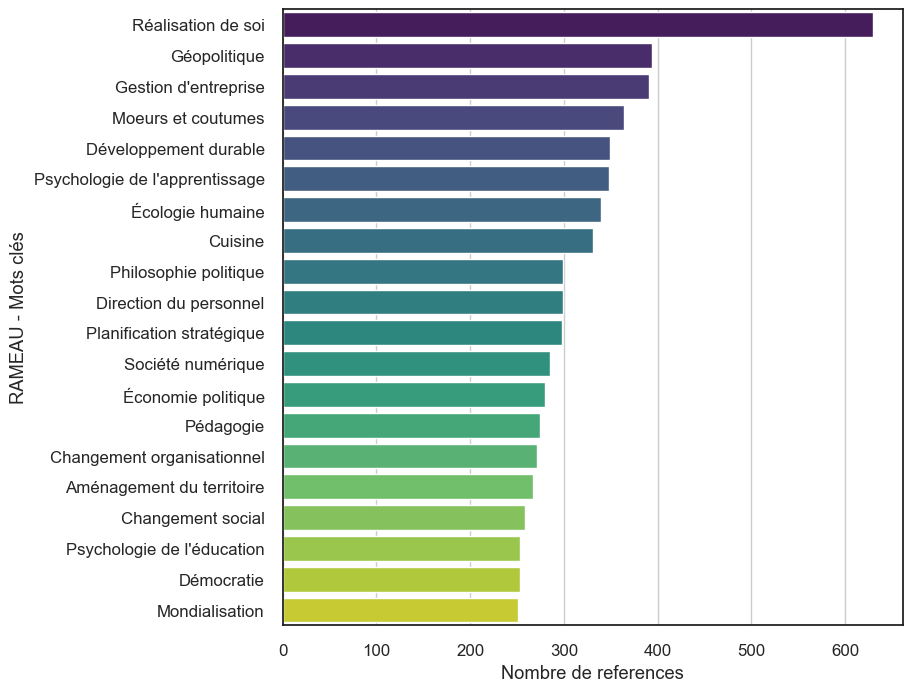

In [23]:
plot_barplot_of_tags(
    tags_list=rameau_list,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords.png',
    figsize=(8, 8))

In [34]:
# Mettre à plat TOUS les mots clé
df["rameau_list_unstack"] = df["RAMEAU"].apply(lambda x: re.split(r';| -- ', x))
df.loc[1:10, "rameau_list_unstack"]

1         [Complexe de castration, Psychanalyse, Rêves]
2                                             [Culture]
3                                      [Structuralisme]
4     [Science-fiction américaine, Traductions franç...
5                                        [Photographie]
6     [Agglomérations urbaines, Aménagement du terri...
7                     [Tarots (cartes à jouer), Contes]
8     [Allégorie de la caverne, Différences entre se...
9     [Attachement, Mères et nourrissons, Personnali...
10               [Philosophes, Philosophie et sciences]
Name: rameau_list_unstack, dtype: object

In [35]:
flatten(df.loc[1:10, 'rameau_list_unstack'])

['Complexe de castration',
 'Psychanalyse',
 'Rêves',
 'Culture',
 'Structuralisme',
 'Science-fiction américaine',
 'Traductions françaises',
 'Photographie',
 'Agglomérations urbaines',
 'Aménagement du territoire',
 'Migrations intérieures',
 'Périurbanisation',
 'Relations villes-campagnes',
 'Tarots (cartes à jouer)',
 'Contes',
 'Allégorie de la caverne',
 'Différences entre sexes (psychologie)',
 'Féminité',
 'Psychanalyse et femmes',
 'Sexualité (psychologie)',
 'Sexualité féminine',
 'Attachement',
 'Mères et nourrissons',
 'Personnalité',
 "Chez l'enfant",
 'Philosophes',
 'Philosophie et sciences']

In [36]:
keywords = flatten(df['rameau_list_unstack'])
keywords

['Culture populaire',
 'Diffusion de la culture',
 'Politique culturelle',
 'Complexe de castration',
 'Psychanalyse',
 'Rêves',
 'Culture',
 'Structuralisme',
 'Science-fiction américaine',
 'Traductions françaises',
 'Photographie',
 'Agglomérations urbaines',
 'Aménagement du territoire',
 'Migrations intérieures',
 'Périurbanisation',
 'Relations villes-campagnes',
 'Tarots (cartes à jouer)',
 'Contes',
 'Allégorie de la caverne',
 'Différences entre sexes (psychologie)',
 'Féminité',
 'Psychanalyse et femmes',
 'Sexualité (psychologie)',
 'Sexualité féminine',
 'Attachement',
 'Mères et nourrissons',
 'Personnalité',
 "Chez l'enfant",
 'Philosophes',
 'Philosophie et sciences',
 'Civilisation',
 'Histoire',
 'Interprétation psychanalytique',
 'Psychanalyse et littérature',
 'Géographie humaine',
 'Technique et civilisation',
 'Urbanisme',
 'Écologie',
 'Discrimination sexuelle',
 'Intégration sociale',
 'Philosophie de la Renaissance',
 'Mathématiques économiques',
 'Théorie des j

In [38]:
len(set(keywords))

21410

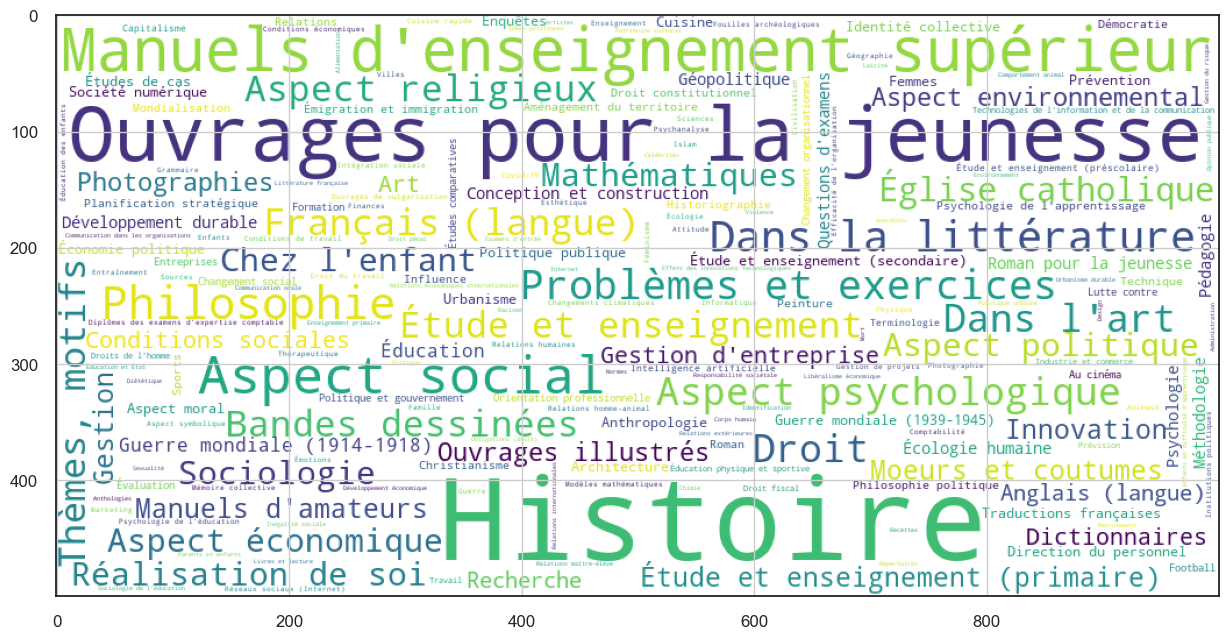

In [42]:
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(Counter(keywords))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

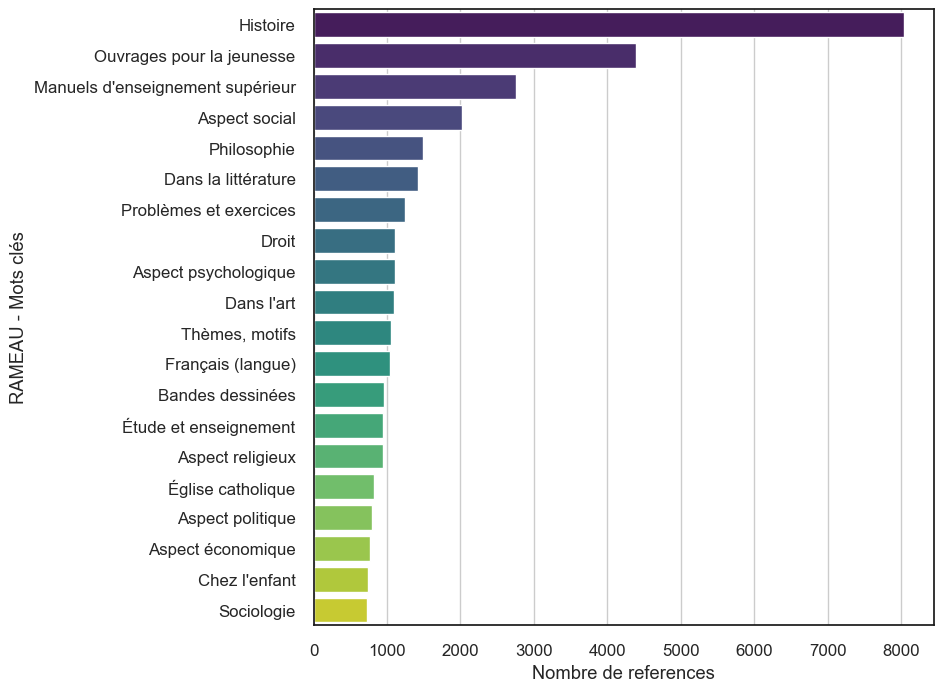

In [40]:
plot_barplot_of_tags(
    tags_list=keywords,
    nb_of_tags=20,
    xlabel="Nombre de references",
    ylabel="RAMEAU - Mots clés",
    figsave='figures/barplot_Rameau_keywords_unstack.png',
    figsize=(8, 8))

## Exploration des titres

In [69]:
list(set(stopwords.words("french")))

['on',
 'étante',
 'serons',
 't',
 'étais',
 'ces',
 'que',
 'eussiez',
 'c',
 'n',
 'serez',
 'eûmes',
 'son',
 'suis',
 'étantes',
 'es',
 'avez',
 'eu',
 'eussions',
 'ne',
 'êtes',
 'serions',
 'leur',
 'sur',
 'fusse',
 'aux',
 'eux',
 'dans',
 'avec',
 'ses',
 'notre',
 'eues',
 'auras',
 'le',
 'soient',
 'pas',
 'soyons',
 'par',
 'eue',
 'eus',
 'seriez',
 'ils',
 'ait',
 'ma',
 'aie',
 'la',
 'fus',
 'été',
 'seraient',
 'en',
 'auraient',
 'votre',
 'elle',
 'au',
 'eûtes',
 'il',
 'fusses',
 'aurait',
 'me',
 'fut',
 'avaient',
 'aura',
 'ayantes',
 'nos',
 'nous',
 'se',
 'ai',
 'aviez',
 'même',
 'y',
 'serais',
 'eût',
 'sont',
 'as',
 'fussiez',
 'aurons',
 'tu',
 'm',
 'seront',
 'fût',
 'furent',
 'avions',
 'ou',
 'pour',
 'toi',
 'étée',
 'étions',
 'ce',
 'eussent',
 'qu',
 'vous',
 'fussions',
 'avons',
 'te',
 'à',
 'des',
 'soit',
 'étant',
 'soyez',
 'mon',
 'de',
 'les',
 'un',
 'une',
 'ayez',
 'aurai',
 'est',
 'aurions',
 'l',
 'eurent',
 'lui',
 'ayant',


In [70]:
# Test function
idx = 1045
text = df.loc[idx, 'TITRE']
print(text)

Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie


In [71]:
doc = nlp("Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie" )
empty_list = []
for token in doc:
    empty_list.append(token.lemma_)

final_string = ' '.join(map(str,empty_list))
print(final_string)

éloge de le folie : adage : colloque : Réflexions sur le éducation , le religion , le guerre , le philosophie


In [72]:
doc = nlp("Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie" )
doc

Éloge de la folie : Adages : Colloques : Réflexions sur l'éducation, la religion, la guerre, la philosophie

In [73]:
# add words
add_words = [
        "la",
        "de",
        "le",
        "les",
        "l",
        "au",
        "du"
]


preprocess_text(
        text, add_words,
        numeric=False, stopw=True,
        stem=False, lem=True)

'éloge folie adage colloque réflexion éducation religion guerre philosophi'

In [74]:
# Test sur un échantillon de notices
df_sample = df.sample(n=20000)

In [75]:
df_sample.shape

(20000, 10)

In [76]:
# Preprocess titres
df_sample['TITRE_processed'] = df_sample['TITRE'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

In [77]:
# Exemple
idx = 65748
print("Titre brut: \n", df_sample.loc[idx, 'TITRE'])
print("\nTitre après processing :\n", df_sample.loc[idx, 'TITRE_processed'])

Titre brut: 
 Séminaire Bourbaki : [avec table par noms d'auteurs de 1948/49 à 2017/18]

Titre après processing :
 séminaire bourbaki table nom auteur 1948 49 2017 18


In [85]:
idx = 57467
# Exemple
print("Titre brut: \n", df_sample.loc[idx, 'TITRE'])
print("\nTitre après processing :\n", df_sample.loc[idx, 'TITRE_processed'])

Titre brut: 
 Goûter à Londres

Titre après processing :
 goûter londre


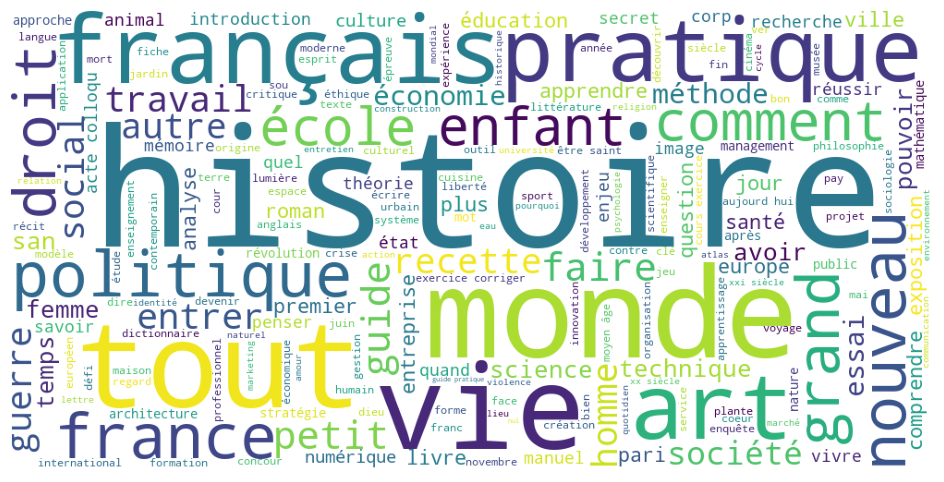

In [87]:
plot_wordcloud(df_sample['TITRE_processed'])

### Exploration des topics (pyLDAvis)

In [91]:
# Vectorization
feature = 'TITRE_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df_sample[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (20000, 300)


In [92]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [93]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.192608  0.250884       1        1  8.386458
7     -0.090039  0.171374       2        1  7.717693
9     -0.036244  0.207138       3        1  7.607240
13    -0.060313 -0.176988       4        1  7.243839
1     -0.012501 -0.078604       5        1  7.212946
2     -0.139063 -0.054342       6        1  7.210292
4      0.307328  0.102650       7        1  6.735583
3     -0.008150 -0.128341       8        1  6.527113
14    -0.045554 -0.034492       9        1  6.410733
11    -0.006573 -0.125040      10        1  6.410227
6     -0.007738 -0.122889      11        1  6.283234
12    -0.104116  0.006125      12        1  6.004523
0      0.192264  0.063205      13        1  5.619042
10     0.215031  0.016090      14        1  5.465390
5     -0.011724 -0.096769      15        1  5.165687, topic_info=         Term        Freq       Total Category  logprob  loglift
130  histoire  474.000000  474.000000  Default  30.0000  30.0000
84      droit  348.000000  348.000000  Default  29.0000  29.0000
179     monde  275.000000  275.000000  Default  28.0000  28.0000
194   nouveau  243.000000  243.000000  Default  27.0000  27.0000
271      tout  246.000000  246.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
271      tout    0.080252  246.549960  Topic15  -9.6368  -5.0670
291    écrire    0.080252   80.733754  Topic15  -9.6368  -3.9506
203     outil    0.080252  110.949347  Topic15  -9.6368  -4.2685
9        2018    0.080252   58.673468  Topic15  -9.6368  -3.6314
160      lieu    0.080252   41.351777  Topic15  -9.6368  -3.2816

[623 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         4  0.974615       10
1         4  0.994689      100
2         1  0.968778       11
3         1  0.973778       15
4        15  0.984630     1914
...     ...       ...      ...
295       2  0.977696  épreuve
296      15  0.992014     état
297       1  0.978785  éthique
298      11  0.994383    étude
299       9  0.990388     être

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 10, 14, 2, 3, 5, 4, 15, 12, 7, 13, 1, 11, 6])

In [94]:
pyLDAvis.save_html(p, "pyldavis_titres_lemma.html")

## Exploration des résumés

In [95]:
# Preproces des résumés
df_sample['RESUME_processed'] = df_sample['RESUME'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

In [ ]:
# Exemple
idx = 4998
print("Résumé brut: \n", df_sample.loc[idx, 'RESUME'])
print("\nRésumé après processing :\n", df_sample.loc[idx, 'RESUME_processed'])

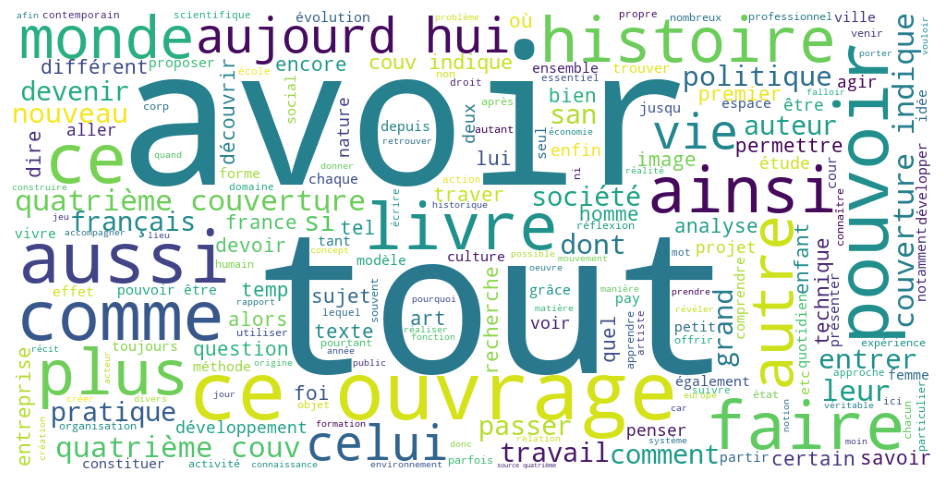

In [96]:
plot_wordcloud(df_sample['RESUME_processed'])

In [97]:
# Vectorization
feature = 'RESUME_processed'
model = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 5),
    min_df=10,
    max_df=0.95)
cv_transform = model.fit_transform(df_sample[feature])
print("Dimensions de la matrice", cv_transform.shape)

Dimensions de la matrice (20000, 300)


In [98]:
# Reduction dimension
n_comp = 15
lda = LatentDirichletAllocation(
    n_components=n_comp,
    learning_method='online',
    random_state=42
    )
x_red = lda.fit_transform(cv_transform)

In [99]:
p = pyLDAvis.sklearn.prepare(lda, cv_transform, model)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.147323  0.007468       1        1  16.225086
5      0.117168  0.049734       2        1  13.040855
10     0.108379  0.075251       3        1  11.911989
14     0.102625  0.094422       4        1  11.564944
2      0.154389  0.033211       5        1  11.025708
12     0.143441 -0.061360       6        1   7.576159
4      0.094164  0.102636       7        1   6.536767
9      0.139586  0.050673       8        1   5.858073
7      0.125761 -0.079025       9        1   4.441121
6     -0.380788  0.146838      10        1   2.501998
0     -0.415437  0.105346      11        1   2.263252
8      0.008426  0.123612      12        1   1.983148
13    -0.035780 -0.283335      13        1   1.826285
3     -0.137948 -0.060200      14        1   1.776448
1     -0.171310 -0.305273      15        1   1.468166, topic_info=          Term         Freq        Total Category  logprob  loglift
89      enfant  1037.000000  1037.000000  Default   30.000  30.0000
230    recette   636.000000   636.000000  Default   29.000  29.0000
22         art   604.000000   604.000000  Default   28.000  28.0000
220  quatrième   729.000000   729.000000  Default   27.000  27.0000
61        couv   542.000000   542.000000  Default   26.000  26.0000
..         ...          ...          ...      ...      ...      ...
44         clé     0.270407   172.174731  Topic15   -8.472  -2.2352
43      chaque     0.270407   313.494396  Topic15   -8.472  -2.8345
270       tout     0.270407  1138.228596  Topic15   -8.472  -4.1239
4     activité     0.270407   215.818163  Topic15   -8.472  -2.4611
200     porter     0.270406   183.818662  Topic15   -8.472  -2.3006

[664 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.067258  aborder
0         2  0.457357  aborder
0         3  0.134517  aborder
0         4  0.085194  aborder
0         5  0.089678  aborder
...     ...       ...      ...
299       5  0.045974     être
299       6  0.129562     être
299       7  0.041794     être
299       8  0.104485     être
299       9  0.041794     être

[2386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 6, 11, 15, 3, 13, 5, 10, 8, 7, 1, 9, 14, 4, 2])

In [100]:
pyLDAvis.save_html(p, "pyldavis_resumes_lemma.html")